In [4]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree
import copy

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm as tqdm
from scipy.signal import find_peaks

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [5]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [6]:
data = pd.read_csv('wtbdata_245days_normal_all.csv')

In [7]:
data

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,time_idx
0,0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,1
1,1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2
2,2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,3
3,3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,4
4,4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,4727515,134,245,23:10,7.79,2.80,-0.07,3.95,216.51,6.03,6.03,6.03,-111.69,601.44,35276
4727516,4727516,134,245,23:20,8.06,4.39,0.23,3.94,216.51,5.81,5.81,5.81,-72.67,673.79,35277
4727517,4727517,134,245,23:30,8.08,2.28,-0.16,4.15,216.51,0.68,0.68,0.68,-118.70,999.36,35278
4727518,4727518,134,245,23:40,8.46,0.80,-0.14,4.32,216.51,0.02,0.02,0.02,-58.12,1100.89,35279


In [8]:
def search_lagpatv_index(data):
    for i in range(len(data.columns)):
        if data.columns[i] == 'Patv_lag_1':
            return i

In [9]:
def lag_feature(data, feat_columns, li):    
    # 在对应的位置设置lag列
    for shift_num in li:
        temp_data = data.groupby(['TurbID'])[feat_columns].shift(shift_num)
        temp_data.columns=[i+"_lag_"+str(shift_num) for i in feat_columns]
        data = pd.concat([data,temp_data],axis=1)
    return data 

In [11]:
def dataset_split(data):
    if 'Tmstamp' in data.columns.tolist():
        data = data.drop('Tmstamp',axis=1)
        
    train_data = data[lambda x: x.time_idx < 30816]
    val_data = data[(data.time_idx>=30816) & (data.time_idx < 34993)]
    test_data = data[lambda x: x.time_idx >= 34993]

    train_feat = train_data.drop('Patv',axis=1)
    train_label = train_data['Patv']
    val_feat = val_data.drop('Patv',axis=1)
    val_label = val_data['Patv']
    test_feat = test_data.drop('Patv',axis=1)
    test_label = test_data['Patv']
    test_individual_feat = []
    test_individual_label = []
    for i in range(data.TurbID.nunique()):
        tmp = test_data.drop('Patv',axis=1).loc[data['TurbID'] == i+1]
        tmp.columns = list(range(len(tmp.columns.tolist())))
        test_individual_feat.append(tmp)
        test_individual_label.append(test_data['Patv'].loc[data['TurbID'] == i+1])
    
    # 为了处理tsfresh的特殊符号列名，直接将所有列名写成数字
#     train_feat.columns = list(range(len(train_feat.columns.tolist())))
#     test_feat.columns = list(range(len(test_feat.columns.tolist())))
    
    return train_feat, train_label, val_feat, val_label, test_feat, test_label, test_individual_feat, test_individual_label

In [9]:
# from lightgbm import log_evaluation, early_stopping
# callbacks = [log_evaluation(period=100), early_stopping(stopping_rounds=20)]

In [12]:
def lgb_(train_feat, train_label, test_feat, test_label):
    gbm = LGBMRegressor(objective='regression', num_leaves=80, learning_rate=0.07, n_estimators=500, max_depth=7)
    gbm.fit(train_feat, train_label, eval_set=[(test_feat, test_label)], eval_metric='rmse', early_stopping_rounds=20)
    return gbm

In [13]:
def lgb_test_new(gbm, data, test_feat, test_label, show=False):
    y_pred = gbm.predict(test_feat)
    patv_min = min(data.Patv)
    patv_max = max(data.Patv)
    for i in range(len(y_pred)):
        if y_pred[i] < 0:
            y_pred[i] = 0
        if y_pred[i] > patv_max:
            y_pred[i] = patv_max

    y_pred_clear = []
    test_label_clear = []
    for i in range(len(y_pred)):
#         if not (test_label.values[i] <= 0):
        y_pred_clear.append(y_pred[i])
        test_label_clear.append(test_label.values[i])
    
    
    # 模型评估
#     print('The rmse of prediction is:', mean_squared_error(test_label, y_pred) ** 0.5)
    pred_rmse = mean_squared_error(test_label_clear, y_pred_clear) ** 0.5
    print('The rmse of prediction is:', pred_rmse)

    # 模型评估
    pred_mae = mean_absolute_error(test_label_clear, y_pred_clear)
    print('The mae of prediction is:', pred_mae)

    # 特征重要度
#     print('{}\nFeature importances:{}'.format([column for column in test_feat], list(gbm.feature_importances_)))
    
    
    if show == True:
        plt.figure(figsize=(20,5))
        plt.plot(range(len(y_pred_clear)), y_pred_clear, label='pred')
        plt.plot(range(len(test_label_clear)), test_label_clear, label='label')
        plt.legend()
        plt.show()
    
    return y_pred_clear,pred_rmse,pred_mae

In [14]:
def get_test_feat(test_feat,test_label,time_idx):
    indexNames=test_feat[test_feat['time_idx'] !=time_idx].index
#     print(indexNames)
    test_feat = test_feat.drop(indexNames)
    test_label= test_label.drop(indexNames)
    return test_feat,test_label

In [15]:
def lag_insert(test_feat, num,index_list): #构造test集函数
    feature_start_index = search_lagpatv_index(test_feat)
    for j in range(1,num+1):
        
        time_idx_list = [m for m in range(34993,34993+j)]

        print(time_idx_list)

        feature_list = test_feat.columns[feature_start_index+j -1:feature_start_index+j]
        print(feature_list)


        for i in range(len(index_list)):
            for feature in feature_list:
                if test_feat.loc[index_list[i],'time_idx'] in time_idx_list:
                    test_feat.loc[index_list[i],feature] = data.loc[index_list[i]-j,'Patv']

                else:
                    test_feat.loc[index_list[i],feature] = np.nan

    return test_feat

In [16]:
def round_pred(gbm1,test_feat,test_label,pred_1,pred_list,rmse_list,mae_list,index_list): #循环预测函数
    
    for i in range(34994,34994+287):
        feature_start_index = search_lagpatv_index(test_feat)
        feature_list = test_feat.columns[feature_start_index:]
        flag = 0
        for j in range(len(index_list)): #用预测的值填充lag1-n

            if test_feat.loc[index_list[j],'time_idx'] == i:

                for f in range(len(feature_list)):

                    if (index_list[j]+f) in index_list: #边界条件判断是否溢出

    #                     print(index_list[j]+flag)
                        test_feat.loc[index_list[j]+f,feature_list[f]] = pred_1[flag]

                flag += 1
#     print(exp_feat)
#     break;
        real_test_feat,real_test_label = get_test_feat(test_feat,test_label,i)
        print('predict:{}/288'.format(i-34993+1))
        pred_1,pred_rmse,pred_mae = lgb_test_new(gbm1, data, real_test_feat, real_test_label)
        print('----------------------------')
        pred_list.extend(pred_1)
        rmse_list.append(pred_rmse)
        mae_list.append(pred_mae)
    return pred_list,rmse_list,mae_list

In [17]:
def single_step_withwspd(wspd_lag,lag_n):
    # 做lag特征
    feat_columns = ['Wspd','Wdir','Etmp','Itmp','Ndir','Pab1','Pab2','Pab3','Prtv']
    li = [i for i in range(288,288+wspd_lag)]
    data_lag1 = lag_feature(data, feat_columns, li)
    
    feat_columns = ['Patv']
    li = [i for i in range(1,lag_n+1)]
    data_lag1 = lag_feature(data_lag1, feat_columns, li)
    data_lag1 = data_lag1.drop(['Wspd','Wdir','Etmp','Itmp','Ndir','Pab1','Pab2','Pab3','Prtv'],axis = 1)
#     data_lag1
    
    #分割数据集
    train_feat, train_label, val_feat, val_label, test_feat, test_label, test_individual_feat, test_individual_label = dataset_split(data_lag1)
    
    # 模型训练
    gbm1 = lgb_(train_feat, train_label, val_feat, val_label)
    
    #获取修改值的index
    index_list = list(test_feat['index'])
    
    #构造单步预测的test集
    test_feat = lag_insert(test_feat, lag_n,index_list)
    print(test_feat)
    
    #取出288时刻中的第一个时刻进行预测
    real_test_feat,real_test_label = get_test_feat(test_feat,test_label,34993)
    
    #保存信息的list
    pred_list,rmse_list, mae_list = [], [], []
    
    #第一个时刻进行预测，pred_1的长度为134，即134个风机的第一个时刻的预测
    pred_1,pred_rmse,pred_mae = lgb_test_new(gbm1, data, real_test_feat, real_test_label)
    
    #记录预测以及误差
    pred_list.extend(pred_1)
    rmse_list.append(pred_rmse)
    mae_list.append(pred_mae)
    
    #循环预测
    print('开始循环预测')
    pred_list,rmse_list,mae_list = round_pred(gbm1,test_feat,test_label,pred_1,pred_list, rmse_list, mae_list,index_list)
    
    return test_label, pred_list,rmse_list,mae_list
    

In [18]:
def single_step(lag_n):
    # 做lag特征
#     feat_columns = ['Wspd']
#     li = [i for i in range(288,288+wspd_lag)]
#     data_lag1 = lag_feature(data, feat_columns, li)
    
    feat_columns = ['Patv']
    li = [i for i in range(1,lag_n+1)]
    data_lag1 = lag_feature(data, feat_columns, li)
    data_lag1 = data_lag1.drop(['Wspd','Wdir','Etmp','Itmp','Ndir','Pab1','Pab2','Pab3','Prtv'],axis = 1)
#     data_lag1
    
    #分割数据集
    train_feat, train_label, val_feat, val_label, test_feat, test_label, test_individual_feat, test_individual_label = dataset_split(data_lag1)
    
    # 模型训练
    gbm1 = lgb_(train_feat, train_label, val_feat, val_label)
    
    #获取修改值的index
    index_list = list(test_feat['index'])
    
    #构造单步预测的test集
    test_feat = lag_insert(test_feat, lag_n,index_list)
    print(test_feat)
    
    #取出288时刻中的第一个时刻进行预测
    real_test_feat,real_test_label = get_test_feat(test_feat,test_label,34993)
    
    #保存信息的list
    pred_list,rmse_list, mae_list = [], [], []
    
    #第一个时刻进行预测，pred_1的长度为134，即134个风机的第一个时刻的预测
    pred_1,pred_rmse,pred_mae = lgb_test_new(gbm1, data, real_test_feat, real_test_label)
    
    #记录预测以及误差
    pred_list.extend(pred_1)
    rmse_list.append(pred_rmse)
    mae_list.append(pred_mae)
    
    #循环预测
    print('开始循环预测')
    pred_list,rmse_list,mae_list = round_pred(gbm1,test_feat,test_label,pred_1,pred_list, rmse_list, mae_list,index_list)
    
    return test_label, pred_list, rmse_list, mae_list
    

In [19]:
test_label, pred_list,rmse_list,mae_list = single_step_withwspd(288,288)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

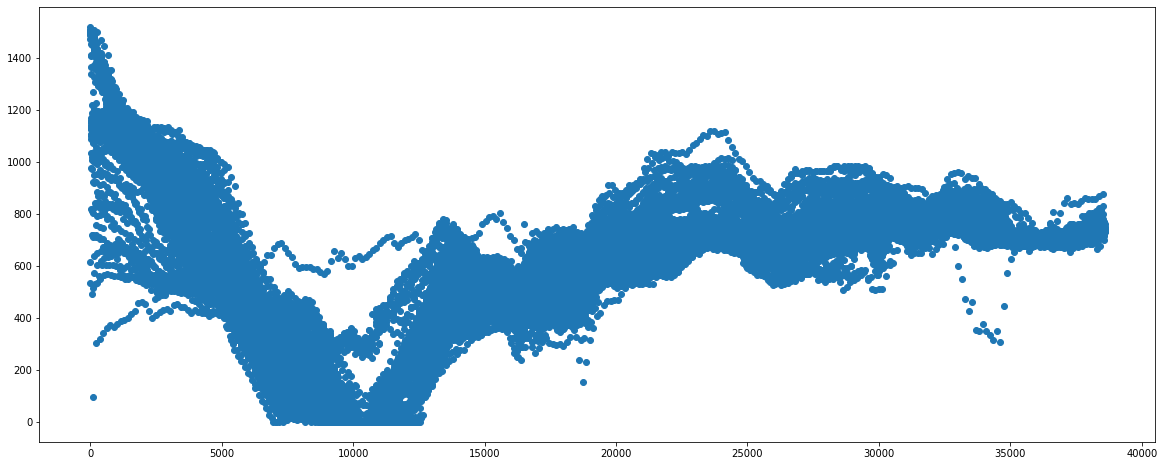

In [25]:
plt.figure(figsize=(20,8))
plt.scatter(list(range(len(pred_list))), pred_list, label='pred')

# plt.plot(list(range(len(test_label))), test_label, label='label')

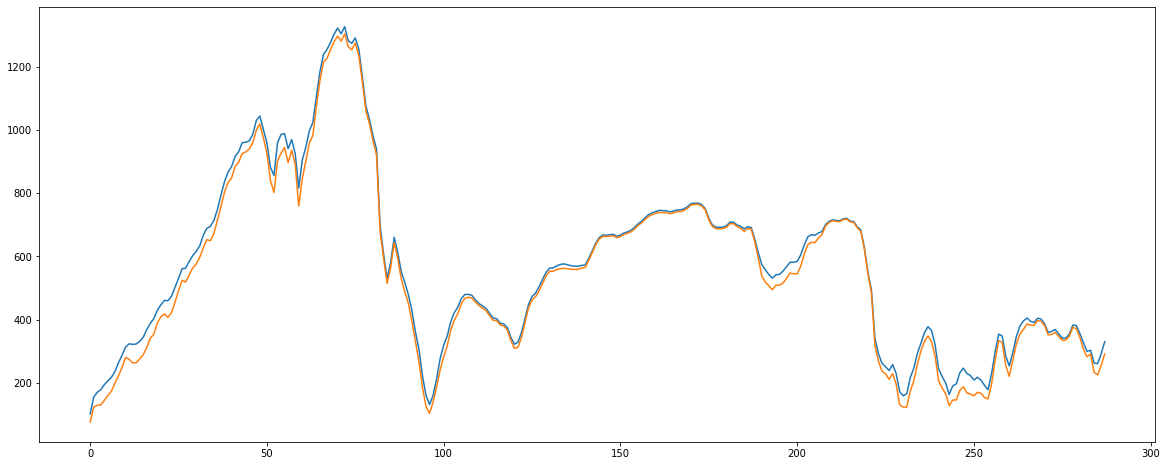

In [26]:
plt.figure(figsize=(20,8))
index_list = [i for i in range(len(rmse_list))]
plt.plot(index_list, rmse_list)
plt.plot(index_list, mae_list)
plt.show()

In [49]:
pred_list,rmse_list,mae_list = single_step(4)

[100]	valid_0's rmse: 62.5316	valid_0's l2: 3910.2
[200]	valid_0's rmse: 61.6056	valid_0's l2: 3795.25
[300]	valid_0's rmse: 61.1998	valid_0's l2: 3745.42
[400]	valid_0's rmse: 60.7365	valid_0's l2: 3688.92
[500]	valid_0's rmse: 60.5104	valid_0's l2: 3661.51
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 60.186	valid_0's l2: 3622.36
[34993]
Index(['Patv_lag_1'], dtype='object')
[34993, 34994]
Index(['Patv_lag_2'], dtype='object')
[34993, 34994, 34995]
Index(['Patv_lag_3'], dtype='object')
[34993, 34994, 34995, 34996]
Index(['Patv_lag_4'], dtype='object')
           index  TurbID  Day  time_idx  Patv_lag_1  Patv_lag_2  Patv_lag_3  \
34992      34992       1  244     34993     1518.49     1518.38     1519.40   
34993      34993       1  244     34994         NaN     1518.49     1518.38   
34994      34994       1  244     34995         NaN         NaN     1518.49   
34995      34995       1  244     34996         NaN         NaN         NaN   
34996      34996     

KeyboardInterrupt: 

In [33]:
turbid_data = []
turbid_pred = []
for i in range(len(test_label)):
    if i%134 == 0:
        turbid_data.append(test_label[i])
        turbid_pred.append(pred_list[i])

KeyError: 0

In [ ]:
plt.figure(figsize=(20,5))
index_tmp = [i for i in range(len(turbid_data))]
plt.plot(index_tmp, turbid_data, label = 'label')
plt.plot(index_tmp, turbid_pred, label = 'pred')
plt.legend()
plt.show()